# TEAM 마음 Ai 분석 제안서

## 온라인 식품시장 트렌드 분석
___

#### 팀원 정보

1. 김성욱
2. 김해주
3. 장원익
___

## 1. 분석 목적

1. 대중이 자주 접할 수 있는 다양한 식품 브랜드에 대한 대중의 시선과 중요하게 생각하는 요소를 도출해 내고자 합니다.
2. 리뷰 데이터를 분석함으로써 다음과 같은 세부 정보를 도출할 수 있습니다.
    * 브랜드 내의 각 메뉴마다의 인식과 선호도 정도
    * 대중이 메뉴를 선택 또는 평가할 때 중요하게 생각하는 요소 (가격, 맛, 포장, 서비스 등등을 예상합니다)
    * 긍정 평가와 부정 평가의 비율 (브랜드 별, 또는 메뉴 별)
3. 같은 식품 업종별로 브랜드 간의 차이를 비교하거나, 브랜드 내 메뉴들 간의 선호 정도를 비교할 수 있습니다. 이를 통해 성공한 메뉴의 특징을 엿보는 것도 기대합니다.

___

## 2. 데이터 수집

### 1) 데이터의 출처
이번 프로젝트에서는 네이버 플레이스의 리뷰 데이터를 이용합니다.
네이버 플레이스 리뷰의 경우 타 SNS 서비스에서 얻을 수 있는 데이터에 비해 아래 장점들이 있어 이 방법을 선택하였습니다.

|               |  네이버 플레이스    |타 SNS|
|-------------  |---------------------|------|
|광고성 게시물  |실제 사용자 리뷰 위주|광고 게시물 다수|
|글의 간결성    |짧은 문장 리뷰 위주  |장문의 글 위주|
|다양한 파라미터|날짜, 별점, 포인트 등|주관적인 기준과 평가|

이번 제안서에서 예시로 사용될 Sample은 아래 두 사이트입니다.

1. 맥도날드 양주옥정DT점          ->   
https://m.place.naver.com/restaurant/1556738021/review/visitor
2. 맘스터치 시흥배곧신도시1호점   ->   
https://m.place.naver.com/restaurant/1569823996/review/visitor

### 2) 데이터 수집 방법
셀레니움을 기반으로 데이터를 수집합니다.
예시 코드를 아래에 서술합니다.

### 2-1) 모듈 설치 코드
```python
!pip install Selenium
!apt-get update
!apt install chromium-chromedriver
!pip install chromedriver-autoinstaller
```
### 2-2) 모듈 Import

In [1]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

from selenium.webdriver.common.by import By
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter
from openpyxl import Workbook
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import pandas as pd
import time
import datetime
import requests

import chromedriver_autoinstaller

### 2-3) 크롤링 진행

간단하게, 다음과 같은 과정을 거쳐 진행합니다.
1. 원하는 매장의 주소로 이동
2. 더보기 버튼을 반복적으로 눌러 리뷰들을 창에 로딩합니다
3. 데이터를 크롤링하여 엑셀 파일로 저장합니다.

#### **맥도날드 양주옥점 DT점의 데이터를 수집하는 예시 코드입니다**

In [34]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

chromedriver_autoinstaller.install()

# 네이버 플레이스 매장 주소
url = "https://m.place.naver.com/restaurant/1556738021/review/visitor"

session = requests.Session()
headers = {
    "User-Agent": "user value"}

retries = Retry(total=5,
                backoff_factor=0.1,
                status_forcelist=[500, 502, 503, 504])

session.mount('http://', HTTPAdapter(max_retries=retries))


now = datetime.datetime.now()
xlsx = Workbook()
list_sheet = xlsx.create_sheet('output')
list_sheet.append(['nickname', 'content', 'date', 'revisit'])


driver = webdriver.Chrome(options=chrome_options)
res = driver.get(url)
driver.implicitly_wait(30)

# 네이브 플레이스 더보기 버튼 클릭
try:
    for _ in range(60):
        # 더보기 버튼 클릭
        more_button = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="app-root"]/div/div/div/div[6]/div[2]/div[3]/div[2]/div/a')))
        more_button.click()
except Exception as e:
    print('finish')

time.sleep(5)
html = driver.page_source
bs = BeautifulSoup(html, 'lxml')
reviews = bs.select('li.owAeM')

# 리뷰 데이터 크롤링
for r in reviews:
        nickname = r.select_one('div.qgLL3>span.P9EZi')
        content = r.select_one('div.vg7Fp.CyA_N')
        date = r.select('div.D40bm>span.CKUdu>time')[0]
        revisit = r.select('div.D40bm>span.CKUdu')[1]

        nickname = nickname.text if nickname else ''
        content = content.text if content else ''
        date = date.text if date else ''
        revisit = revisit.text if revisit else ''
        time.sleep(0.06)

        print(nickname, '/', content, '/', date, '/', revisit)
        list_sheet.append([nickname, content, date, revisit])
        time.sleep(0.06)

# 크롤링한 데이터 엑셀로 저장
file_name = '맥도날드' + now.strftime('%Y-%m-%d_%H-%M-%S') + '.xlsx'
xlsx.save(file_name)

하림채아윤 /  / 3.24.일 / 2번째 방문
리뷰써보기 / 상하이는 순삭해서 사진이 없네요ㅋㅋㅋ 양상추, 토마토 신선해서 맛있게 먹었어요. 사진에 추가로 주문한 더블불고기도 패티, 소스, 양상추,치즈 모두 푸짐했어요,감튀도 맛있더라고요 다른덴 다 마른 감잔데 오랜만에 맛있게 먹었습니다♡ / 3.17.일 / 1번째 방문
껀블리 / 포장해서 먹었는데 기프티콘 사용할거라 맥드라이브 대신 주차장에 주차하고 픽업했어요! 식사시간 근접해서 그런
지 주차장에 자리가 부족했어용  주문을 많이해서 혹시나 누락있을까봐 받자마자 포장 뜯고 확인해봤는데 역시나 
치즈스틱누락.. 말씀드리니까 바로 챙겨주셨어요! 맥날은 언제 먹어도 든든하고 맛있습니당 내용 더보기 / 4.13.토 / 1번째 방문
주주46 / 오랜만에 베이컨토마토디럭스버거를 사먹어봤는데요, 맥도날드는 빵이 쫄깃하고 맛있네요! 할인행사같은거  많이 했으면 좋겠어요~~ 버거세트 두 개에 윙 추가했는데 3만원이 넘게 나오네요ㅠㅠ  / 4.4.목 / 1번째 방문
현듀와나들이 / 커피너무조금주시네요  얼음만가득해요.  드라이브스루로 구입했는데 코너가 돌기도 넓고 좋습니다.내용 더보기 / 4.1.월 / 1번째 방문
미놈친아 / 매장 깔끔하고 조용하고 아주 좋습니다 직원분께서 테이블서비스 추천해주셔서 이용하였는데 2층까지 가져다주셨
습니다  테이블서비스 처음이용하였는데 아주 편리하고 유용한 서비스네요  친절하게 응대해주셔서 감사합니다.내용 더보기 / 4.3.수 / 1번째 방문
바이올렛7132 / 홀에 계시는분 친절하세요.  / 4.28.일 / 1번째 방문
sera1216 / 맥플러리~ 너무 작아졌지만 맛있어요~~!! / 4.25.목 / 2번째 방문
훈유니 / 체인점이니 그럭저럭 평타는 합니다
이름은 왜 옥정인지 모르겠어요 고읍이라고 하는게 더 찾기 편할 듯합니다 / 4.5.금 / 1번째 방문
좋았으면리뷰에하트 / 직원분이 너무 친절하고 매장이 깨끗하고 쾌적해서 즐겁게 이용하고 갑니다!! 직원분이 정말정말 놀라울만큼 친절
합니다 

### 2-4) 수집된 데이터의 구조 및 설명

*   nickname : 사용자의 아이디 또는 닉네임
*   content: 사용자가 작성한 리뷰 내용. 리뷰는 제품 또는 브랜드에 대한 사용자의 경험과 의견을 포함.
*   date : 리뷰가 작성된 날짜.
*   revisit : 사용자가 해당 매장을 방문한 횟수.

#### **수집한 데이터의 형태를 나타냅니다**

In [3]:
import numpy as np
import pandas as pd

In [35]:
df = pd.read_excel(f"./{file_name}", sheet_name="output")
df.head(7)

,nickname,content,date,revisit
0,하림채아윤,NaN,3.24.일,2번째 방문
1,리뷰써보기,"상하이는 순삭해서 사진이 없네요ㅋㅋㅋ 양상추, 토마토 신선해서 맛있게 먹었어요. 사...",3.17.일,1번째 방문
2,껀블리,포장해서 먹었는데 기프티콘 사용할거라 맥드라이브 대신 주차장에 주차하고 픽업했어요!...,4.13.토,1번째 방문
3,주주46,"오랜만에 베이컨토마토디럭스버거를 사먹어봤는데요, 맥도날드는 빵이 쫄깃하고 맛있네요!...",4.4.목,1번째 방문
4,현듀와나들이,커피너무조금주시네요 얼음만가득해요. 드라이브스루로 구입했는데 코너가 돌기도 넓고...,4.1.월,1번째 방문
5,미놈친아,매장 깔끔하고 조용하고 아주 좋습니다 직원분께서 테이블서비스 추천해주셔서 이용하였는...,4.3.수,1번째 방문
6,바이올렛7132,홀에 계시는분 친절하세요.,4.28.일,1번째 방문


___
## 3. 데이터 전처리

데이터의 결측치 등을 처리하는 단계를 거칩니다.

전처리 과정은 다음 단계로 정리할 수 있습니다.
> 1. info를 확인합니다. (사용자 편의)
2. 리뷰 내용이 없는 리뷰 (결측치)를 제거합니다.
3. revisit 열을 정수형 데이터로 전환합니다. 

#### info를 사용하여 출력한 정보입니다.
```python
df.info()
```

```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 S   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   nickname  20 non-null     object
 1   content   17 non-null     object
 2   date      20 non-null     object
 3   revisit   20 non-null     object
dtypes: object(4)
memory usage: 772.0+ bytes
```

#### **df.isnull().sum()** 를 사용하면 content에 null이 있는 것을 알 수 있습니다.

```
nickname    0
content     3
date        0
revisit     0
dtype: int64
```

아래는 코드 진행 예시입니다.

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   nickname  50 non-null     object
 1   content   45 non-null     object
 2   date      50 non-null     object
 3   revisit   50 non-null     object
dtypes: object(4)
memory usage: 1.7+ KB


In [37]:
df.isnull().sum()

nickname    0
content     5
date        0
revisit     0
dtype: int64

In [18]:
import re

In [38]:
# 결측치 제거
df2 = df.dropna(axis=0)
df2.isnull().sum()

# revisit 열 재구성
df2.loc[:, 'revisit'] = df2['revisit'].apply(lambda x: x[0])
df2.loc[:, 'revisit'] = df2['revisit'].astype(int)

# 열 확인
print(df2['revisit'].iloc[:7])

1    1
2    1
3    1
4    1
5    1
6    1
7    2
Name: revisit, dtype: object


___

## 4) 데이터 탐색 및 시각화

자연어 처리가 이루어지지 않은 단계이기 때문에 현재 간단히 진행할 수 있는 분석 코드 몇 가지를 통해 데이터를 살펴보도록 하겠습니다.

### describe

In [39]:
df2.describe()

,nickname,content,date,revisit
count,45,45,45,45
unique,43,45,33,4
top,sera1216,"상하이는 순삭해서 사진이 없네요ㅋㅋㅋ 양상추, 토마토 신선해서 맛있게 먹었어요. 사...",2.10.토,1
freq,2,1,3,35


## 4-1) 간단한 토큰화 작업을 통한 많이 등장하는 단어 살펴보기



아주 간단한 토큰화를 거쳐 가장 많이 등장하는 단어를 그래프로 시각화하는 부분입니다.
데이터가 작고 자연어 처리 과정이 들어가지 않아 의미 있는 데이터를 도출한다기보다는, 데이터의 형태 및 내용을 대략적으로 짐작해 볼 수 있습니다.


In [45]:
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [46]:
# 한글 사용하기

# 글꼴 경로 지정
font_path = 'C:\\Windows\\Fonts\\malgun.ttf'

# 폰트 이름 지정
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

In [60]:
# 'content' 열의 데이터 타입을 문자열로 변환
df2.loc[:, 'content'] = df2['content'].astype(str)

# 'content' 열에 대해 공백을 기준으로 토큰화하는 함수 정의
def tokenize_by_space(text):
    tokens = text.split()  # 공백을 기준으로 텍스트를 분리하여 리스트로 반환
    return tokens

# 'content' 열에 대해 토큰화 수행
df2.loc[:,'tokenized_content'] = df2['content'].apply(tokenize_by_space)

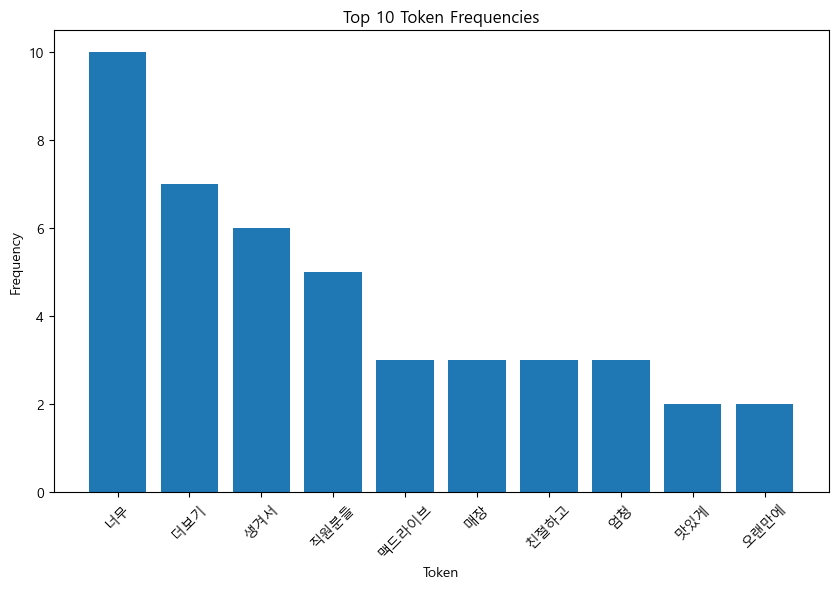

In [71]:
# 모든 토큰을 하나의 리스트로 펼침
all_tokens = [token for sublist in df2['tokenized_content'] for token in sublist]
# all_tokens = [x for x in all_tokens if len(x) > 1]

# 토큰의 빈도 계산
token_counter = Counter(all_tokens)

# 가장 빈도가 높은 상위 10개 토큰 추출
top_tokens = token_counter.most_common(10)

# 그래프 그리기
labels, values = zip(*top_tokens)
plt.figure(figsize=(10, 6))
plt.rc('font', family='Malgun Gothic')
plt.bar(labels, values)
plt.title('Top 10 Token Frequencies')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

## 4-2) 누적 방문 횟수 살펴보기

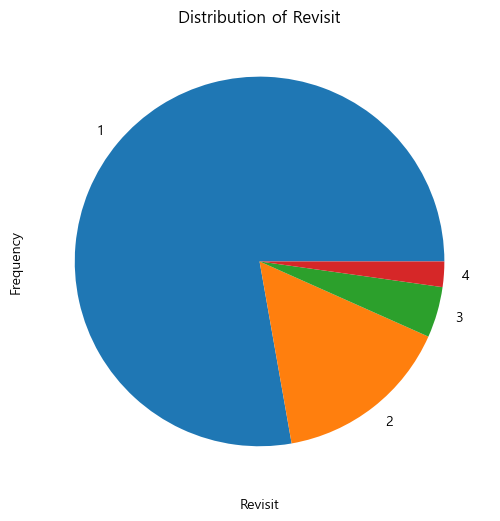

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df2['revisit'].value_counts().plot(kind='pie')
plt.title('Distribution of Revisit')
plt.xlabel('Revisit')
plt.ylabel('Frequency')
plt.show()